# **`Analysis of Sex-Based Differences in Age of Cardiovascular Disease Patients`**

#### STAT 201 Group Project Proposal ####
##### Group 17 - *Janice Chan, Ena Gupta, Gael Hernandez Palmer*

### Introduction

As it currently stands, cardiovascular disease (CVD) is the second leading cause of death for Canadians (Statistics Canada, 2022). Over years of study, scientists have been able to identify and track certain risk factors for CVD in order to better inform prevention and mitigation efforts. Sex-based differences in both the prevalence and clinical presentation of CVDs have long been a topic of interest with men being afflicted by the disease both more frequently and earlier in their lives (P.H.A of Canada, 2017). The male-focused lens in studying CVDs has historically meant considerable rates of underdiagnosis for women and a misunderstanding of the differences in presentation of disease. 
 
In this project, our aim is to use compiled data to quantify the difference in mean age between men and women suffering from CVD and their respective standard deviations. To achieve this we will be using the “Heart Disease Data Set” published on the UCI Machine Learning Repository by David Aha. We have selected the Cleveland Clinic database as opposed to the European databases to obtain results that can be generalized to the greater Canadian public based on similar lifestyle and socio-economic distributions between the United States and Canada (Solé-Auro et al., 2017). We utilize the bootstrap method, hypothesis testing, and confidence intervals along with visualizations for a well-informed analysis using inferential tools as a guide.

### Dataset:

https://archive.ics.uci.edu/ml/datasets/Heart+Disease

By: David W. Aha

### Preliminary Results

In [16]:
# Load packages
library(digest)
library(infer)
library(repr)
library(tidyverse)
library(dplyr)
library(ggplot2)

In [17]:
# set seed for reproducibility
set.seed(1234)

# HEART DISEASE DATA (Compiled)
# load data

heart_disease_data <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
                                 delim = ",",
                                 col_names = FALSE) %>%
    transmute(age = X1, # clean data; renaming
              
              sex = factor(X2) %>%
                  fct_recode(female = "0", # binary -> factors
                             male = "1"),
              
              chest_pain = factor(X3) %>% # Type of chest pain reported
                  fct_recode(typical_angina = "1", # numerical -> factors
                             atypical_angina = "2",
                             nonanginal_pain = "3",
                             asymptomatic = "4"),
              
              resting_bp = X4, # Resting blood pressure (mm/Hg)
              
              cholesterol = X5, # Total cholesterol (mg/dL)
              
              bldsg_over120 = factor(X6) %>% # Indicates wether the patient's blood sugar is over 120 mg/dL
                  fct_recode(no = "0", # binary -> factors
                             yes = "1"),
              
              rest_ecg = factor(X7) %>% # Resting ECG results
                  fct_recode(normal = "0", # numerical -> factors
                             stt_abnormal = "1", 
                             lv_hyptroph = "2"),
              
              max_hr = X8, # Maximum observed heart rate
              
              ex_angina = factor(X9) %>% # Presence of exercise induced angina
                  fct_recode(no = "0", # binary -> factors
                             yes = "1"),
              
              old_peak = X10, # ST depression induced by exercise relative to rest
              
              slope = factor(X11) %>% # Slope of peak exercise ST segment
                  fct_recode(upslope = "1", # numerical -> factors
                             flat = "2",
                             downslope = "3"),
              
              flr_ves = X12, # Number of vessels coloured by fluoroscopy
              
              thalassemia = factor(X13) %>% 
                  fct_recode(normal = "3.0", # numerical -> factors
                             fxd_def = "6.0",
                             rev_def = "7.0"),
              
              disease = factor(X14) %>% # Disease progression
                 fct_recode(no = "0", # numerical -> factors
                            yes = "1",
                            yes = "2", # 1-4 indicate disease progression 
                            yes = "3", # for our analysis we only care about absence/presence of disease
                            yes = "4")) 

## **NOTE**: 
## Code refactoring was done based on provided attribute information which can be accessed at:
## https://raw.githubusercontent.com/Gaelhpalmer/STAT201Project/main/desc.names

print("Table 1. Cleveland Heart Disease Data.")
head(heart_disease_data)


diseased <- heart_disease_data %>%
    filter(disease == "yes") %>% # filter for those diagnosed with heart disease
    select(age, sex) # select relevant attributes

# Heart disease data for diseased male patients
male_diseased = diseased %>%
    filter(sex == "male") # filter for males

print("Table 2. Diseased Males.")
head(male_diseased)

# Heart disease data for diseased female patients
female_diseased = diseased %>%
    filter(sex == "female")  # filter for those females

print("Table 3. Diseased Females.")
head(female_diseased)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1. Cleveland Heart Disease Data."


age,sex,chest_pain,resting_bp,cholesterol,bldsg_over120,rest_ecg,max_hr,ex_angina,old_peak,slope,flr_ves,thalassemia,disease
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<chr>,<fct>,<fct>
63,male,typical_angina,145,233,yes,lv_hyptroph,150,no,2.3,downslope,0.0,fxd_def,no
67,male,asymptomatic,160,286,no,lv_hyptroph,108,yes,1.5,flat,3.0,normal,yes
67,male,asymptomatic,120,229,no,lv_hyptroph,129,yes,2.6,flat,2.0,rev_def,yes
37,male,nonanginal_pain,130,250,no,normal,187,no,3.5,downslope,0.0,normal,no
41,female,atypical_angina,130,204,no,lv_hyptroph,172,no,1.4,upslope,0.0,normal,no
56,male,atypical_angina,120,236,no,normal,178,no,0.8,upslope,0.0,normal,no


[1] "Table 2. Diseased Males."


age,sex
<dbl>,<fct>
67,male
67,male
63,male
53,male
56,male
48,male


[1] "Table 3. Diseased Females."


age,sex
<dbl>,<fct>
62,female
65,female
61,female
51,female
62,female
60,female


In [18]:
# summarize data (estimates)

# Instances 
n_total <- nrow(diseased)
n_male <- nrow(male_diseased)
n_female <- nrow(female_diseased)

# Average age in male patients
mean_age_male = mean(male_diseased$age) %>%
    round(digits = 2)


# Standard deviation of age in male patients
sd_age_male = sd(male_diseased$age) %>%
    round(digits = 2)


# Average age in female patients
mean_age_female = mean(female_diseased$age) %>%
    round(digits = 2)


# Standard deviation of age in female patients
sd_age_female = sd(female_diseased$age) %>%
    round(digits = 2)

##### Table 4. Number of Instances of Sex.

| Male | Female | Total|
|------|--------|------|
| 114 | 25 | 139|


##### Table 5. Average Age of Heart Disease Patients by Sex.
| Male patients      | Female patients |
| ----------- | ----------- |
| 56.09      | 59.08       |

##### Table 6. Standard Deviation of Age in Heart Disease Patients by Sex.
| Male patients      | Female patients |
| ----------- | ----------- |
| 8.39     | 4.86       |

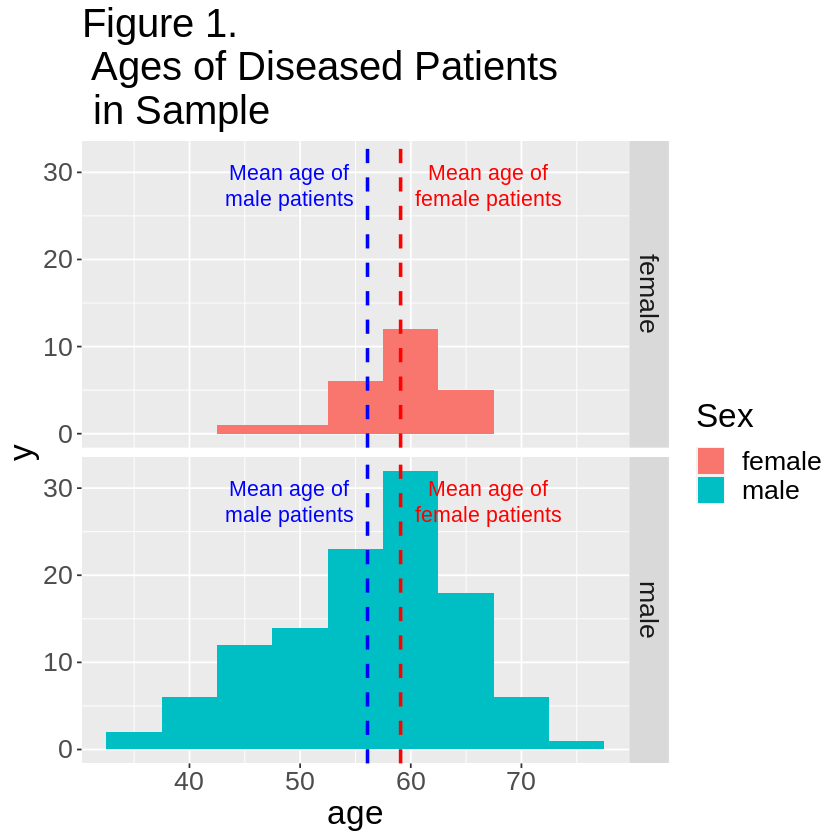

In [29]:
# plot raw data

# Both male and female patients
age_plot <- diseased %>%
    ggplot(aes(x = age, fill = sex)) +
    geom_histogram(binwidth = 5) +
    facet_grid(rows = vars(sex)) +
    geom_vline(xintercept = mean_age_male, linetype = "dashed", size = 1, color = "blue") + # mean age of male patients
    geom_vline(xintercept = mean_age_female, linetype = "dashed", size = 1, color = "red") + # mean age of female patients
    labs(title = "Figure 1. \n Ages of Diseased Patients \n in Sample",
         xlab = "Age",
         ylab = "Count",
         fill = "Sex") +
    annotate("text", x = 67, y = 30, label = "Mean age of", color="red", size=4.5) +
    annotate("text", x = 67, y = 27, label = "female patients", color="red", size=4.5) +
    annotate("text", x = 49, y = 30, label = "Mean age of", color="blue", size=4.5) +
    annotate("text", x = 49, y = 27, label = "male patients", color="blue", size=4.5) +
    theme(text = element_text(size = 20))

age_plot

### Inferential Analysis

#### Bootstrapping:

[1] "Table 7. Bootstrap Generated."


replicate,stat,samp_dist
<int>,<dbl>,<chr>
1,5.267529,Actual
2,4.609127,Actual
3,2.843585,Actual
4,1.175210,Actual
5,2.638158,Actual
6,2.124426,Actual


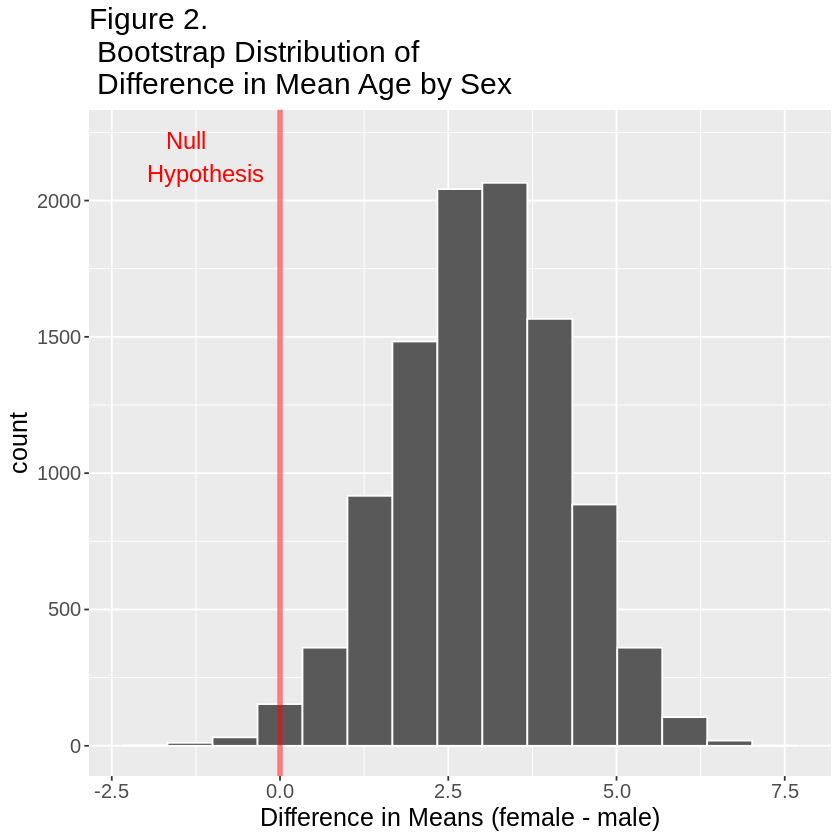

In [28]:
# Data resampling, calculation of difference in means & visualization
# Infer package is used to simplify process

# Boostrap Generated
age_bootstrap <- diseased %>%
    specify(formula = age ~ sex) %>% # specify response and explanatory variables
    generate(reps = 10000, type = "bootstrap") %>% # generate bootstraps
    calculate(stat = "diff in means", order = c("female", "male")) %>% # calculate difference in means
    mutate(samp_dist = "Actual")
print("Table 7. Bootstrap Generated.")
head(age_bootstrap) # show bootstraps

# Summary Statistics Calculated, Visualized
age_bootstrap_vis <- age_bootstrap %>%
    visualize() + 
    xlab("Difference in Means (female - male)")+
    ggtitle("Figure 2. \n Bootstrap Distribution of \n Difference in Mean Age by Sex") +
    geom_vline(xintercept = 0, colour = "red", lwd = 1.5, alpha = 0.5) + # null hypothesis
    annotate("text", x = -1.4, y = 2222, label = "Null", color="red", size=5) +
    annotate("text", x = -1.1, y = 2100, label = "Hypothesis", color="red", size=5) +
    theme(text = element_text(size = 15)) 
age_bootstrap_vis

In [21]:
# Standard deviation

sd_resample <- diseased %>% 
    rep_sample_n(size = nrow(diseased), replace = TRUE, reps = 10000) %>% #resampling
    group_by(replicate, sex) %>% #grouping
    summarize(sd = sd(age)) #calculation of SD

sd_male <- sd_resample %>%
    filter(sex == "male")  #filtering for males
sd_male <- mean(sd_male$sd) #calculating mean by extracting vector

sd_female <- sd_resample %>%
    filter(sex == "female") #filtering for females
sd_female <- mean(sd_female$sd) #calculating mean by extracting vector


`summarise()` has grouped output by 'replicate'. You can override using the
`.groups` argument.



##### Table 8. Bootstrap Average Standard Deviation of Ages by Sex.
| Male patients      | Female patients |
| ----------- | ----------- |
|8.32746156126434|4.64998573728774|

#### Hypothesis Testing:

Previous research suggests that there is likely a difference in the mean age at which men and women suffer from CVDs, with men being afflicted earlier in their lives. Consequently, we have selected our hypothesis as:

H0: $\mu$female - $\mu$male = 0



H1: $\mu$female - $\mu$male > 0

Moreover, we are setting our significance level (p-value) to:

$\alpha$ = 0.05

In [22]:
# Hypothesis testing via Infer package

#observed test statistic
obs_diff_means <- diseased %>%
    specify(formula = age ~ sex) %>% #set response and explanatory variables
    calculate(stat = "diff in means", order = c("female", "male")) %>% #set intended test statistic
    pull()

Table 9. Observed Difference in Means in Data.

|Test Statistic|
|-----|
|2.99228070175438|

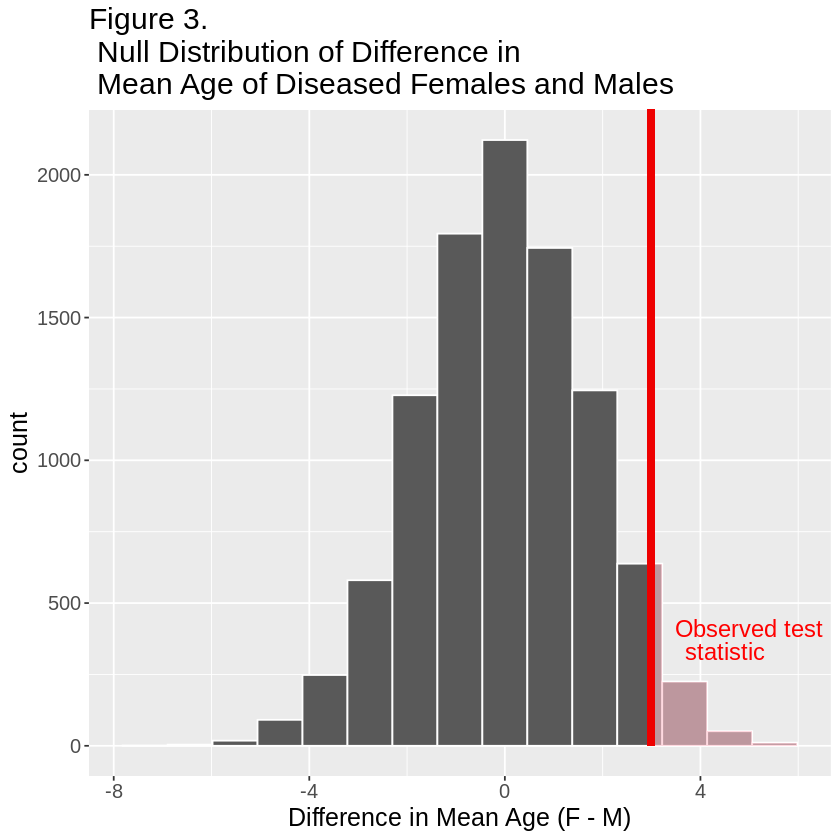

In [23]:
#generation of null distribution
age_null <- diseased %>%
    specify(formula = age ~ sex) %>% #set response and explanatory variables
    hypothesize(null = "independence") %>% #set hypothesis type
    generate(reps = 10000, type = "permute") %>% #generate replicates via permutation
    calculate(stat = "diff in means", order = c("female", "male")) %>% #set intended test statistic
    mutate(samp_dist = "Null Model")

visualize(age_null) + 
    shade_p_value(obs_stat = obs_diff_means, direction = "right") +
    ggtitle("Figure 3. \n Null Distribution of Difference in \n Mean Age of Diseased Females and Males") +
    xlab("Difference in Mean Age (F - M)") +
    annotate("text", x = 5, y = 410, label = "Observed test", color="red", size=5) +
    annotate("text", x = 4.5, y = 330, label = "statistic", color="red", size=5) +
    theme(text = element_text(size = 15))

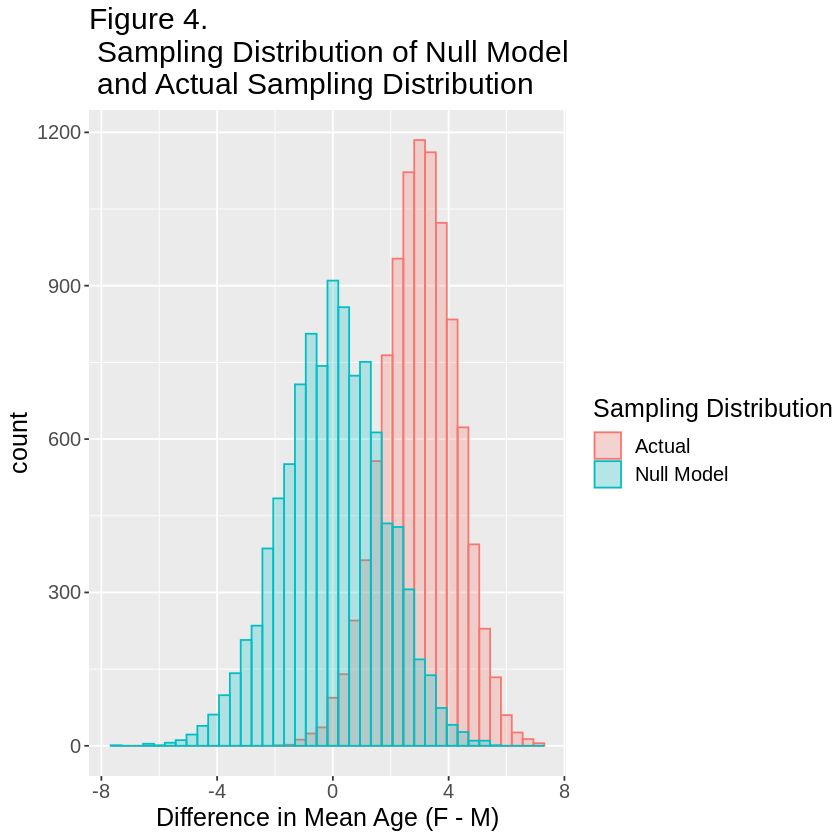

In [24]:
# Constrasting the null model and the actual sampling distribution
null_actual_samp_dist <- age_bootstrap %>% 
    bind_rows(age_null) %>% 
    ggplot() + 
    geom_histogram(aes(stat, color=samp_dist, fill=samp_dist), alpha=.25, bins=40, position="identity" ) +
    theme(text = element_text(size=20)) + 
    labs(title = "Figure 4. \n Sampling Distribution of Null Model \n and Actual Sampling Distribution", 
         x = "Difference in Mean Age (F - M)",
         fill = "Sampling Distribution",
         color = "Sampling Distribution") +
    theme(text = element_text(size = 15))

null_actual_samp_dist

In [25]:
#p-value extraction
p_value <- age_null %>%
    get_p_value(obs_stat = obs_diff_means, direction = "right")

Table 10. Calculated P-Value.

|P-Value|
|-------|
|0.0385 |

#### Constructing 95% Confidence Interval

In [26]:
bootstrap_ci <- age_bootstrap %>%
    select(replicate, stat) %>%
    get_ci(level = 0.95) #extraction of 95% CI using Infer Package


Table 11. 95% Confidence Interval based on Bootstrap Distribution.

|Lower Bound|Upper Bound|
|----|----|
|0.4512817|5.406216|


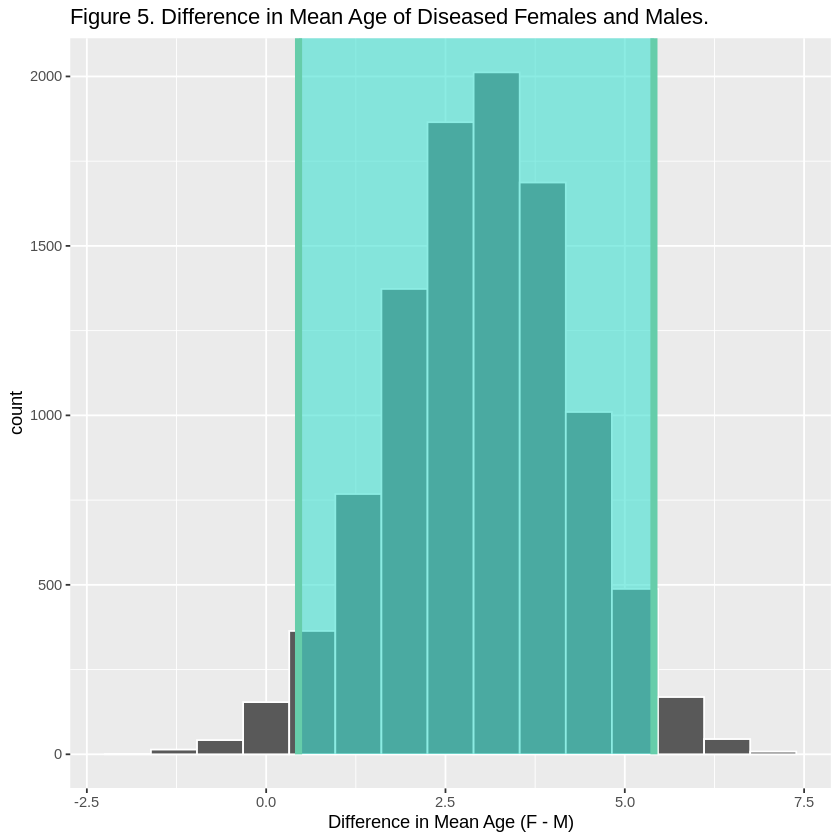

In [27]:
#CI Visualization

visualize(age_bootstrap) +
    shade_confidence_interval(endpoints = bootstrap_ci) +
    xlab("Difference in Mean Age (F - M)") +
    ggtitle("Figure 5. Difference in Mean Age of Diseased Females and Males.")

### Methods and Results

First, in our preliminary analysis we look at the Cleveland data as the representative sample of our population of interest, Canadian CVD patients. We calculated the mean age of both men and women in the sample suffering from CVD to compare with previous research, and the standard deviation of ages to see variability and consistency, which helped us better understand the clinical presentation of CVDs between the sexes. We calculated these sample statistics presented in Tables 5 and 6, examining our parameters of interest: average age and standard deviation.

Tables 5 and 6 along with Figure 1 display the mean ages for male and female patients from the data respectively. Given that the Cleveland data is such as small sample of data from a population other than that of interest, and that there is a notable difference in sample size between male and female patients summarized in Table 4, preliminary analysis alone is not enough to generalize to our population in our question of interest.

Next, with the Cleveland data as our sample, we used the infer package workflow to generate a bootstrap distribution with 10,000 resamples to estimate the difference in means and standard deviation for the age of male and female CVD patients in Canada. The summary statistics are seen in Figure 2 and Table 8. We calculated the parameters of interest (difference in mean ages by sex and standard deviation of ages by sex) from the bootstrap sample to estimate these values for our population, Canada.
To answer our research question, wether there is a statistically significant difference in mean ages of CVD patients by sex, we performed a one-sided hypothesis test; calculating the p-value from our bootstrap sample to determine if the results supported the claims of previous research. Our null hypothesis was that the difference in mean ages was zero (the mean ages are the same between sexes) and the alternative hypothesis was that the mean age of men suffering from CVDs is lower than that of women, representing the claims from previous research. We set our significance level to 0.05 for a 5% risk of incorrectly agreeing with the alternative hypothesis. Subsequently, We constructed the null model and compared it with the bootstrap sampling distribution in Figures 3 and 4.

Finally, we used the infer package workflow to extract a 95% confidence interval of where our population difference of means is likely to fall within. 
 
Based on preliminary findings summarized in figure 1 as well as tables 4-6, a difference in average age of diseased patients between both sexes which was already noted. Upon completion of hypothesis testing, we have rejected the null hypothesis, siding with previous research claims: the average age for male patients is lower than the average age for female patients. While we also note that the standard deviation for age in male patients is higher, the number of instances of men and women in the wrangled dataset also differ largely which may have an impact on observed standard deviation.

Looking at the bootstrap results, the difference in mean ages is close to 3 years (Table 9) which is very close to the preliminary results of the subtracting the mean male age from the mean female age in Table (59.08-56.09). The difference in means is our intended point estimate of the difference in mean ages between female and male CVD patients in Canada. The standard deviation (as shown in Table 8) is also similar to what was calculated in the preliminary analysis (Table 6), with the male patients' ages having higher standard deviation than that of female patients' ages. This suggests more variability and less consistency in the ages seen in male CVD patients. In turn, the lower mean age for males could be due to larger variability in ages, having more younger males suffering from CVDs than females.

When deciding between methods of bootstrapping or asymptotic analyses, bootstrapping was deemed more appropriate as the Central Limit Theorem assumptions were not met. With our intended population being CVD patients in Canada, the total sample size of that shown in Table 4 was not large enough.

Comparing the bootstrap with the null model, in Figures 2 and 4 we can see the overlap between the two of the chance the actual sampling distribution generates a test statistic in the region of non-rejection of the null hypothesis, associated with type II error and power. We can see how the bootstrap is distributed relative to the null model and what the difference of means is relative to the null model.

From calculating the p-value seen in Table 10, we got a value of 0.0385 which is smaller than our 0.05 significance level. This means that the test is statistically significant. Therefore, we reject the null hypothesis that the mean ages for both sexes of CVD patients are the same, and favour the alternative hypothesis supporting previous research that male patients have a lower average age compared to female patients.

The 95% confidence interval of the bootstrap distribution for difference in means age of females and males indicate that we are 95% confident that the true population mean is captured in the range of the 95% confidence interval, [0.4512817, 5.406216].

### Discussion

Based on previous studies and preliminary analysis of the data, we expected to find a statistically significant difference in the mean age of men and women suffering from CVDs, with the age of men being lower than that of women (Mosca et al., 2011). Our hypothesis testing results from bootstrapping our data agrees with the previous study and our prediction, answering our question that in Canada, male patients suffering from CVDs should have a lower age on average compared to female patients. We also found that the standard deviation of men was greater than that of women in the sample. 

In our hypothesis testing, a standard p-value of of 5% was selected as the threshold for statistical significance. In making this decision, we took into consideration the implications of making a type 1 error (which would imply finding the mean age of CVD patients is the same between men and women when it was not) and the intended goal of this study, which was a simple understanding of disease presentation between the sexes. It was decided that a more stringent p-value would not be necessary, as committing type 1 error would have minor/no negative consequences on disease outcomes for patients.

It is, however, important to mention the limitations of our analysis and research question given our dataset. As previously mentioned, we elected to use the Cleveland Clinic subset of data to represent our population of interest: CVD patients in Canada. While we believe that results based on data from the United States would generalize best to Canada as compared to available European datasets (given similar cultures, lifestyles, and diets), we ackgnowledge that there may be demographic differences or minor differences in disease presentation between the two countries. Moreover, the fairly small size of the cleveland dataset limits the generalizability of our results to the greater population and may mean greater variability in our analysis than what would be seen in the population.

Still, despite its limitations, our analysis should provide some understanding in the difference in clinical presentation of CVDs between the sexes and it is our hope that it could contribute to more informed diagnoses for patients. Moreover, these findings, along with further research into female-specific risk factors and disease mitigation, could help shape clinical practice and improve disease outcomes for women.

Additionally, age is just one general trait that we can examine between CVD patients. Further research can enhance understanding the different ways CVD impacts patients between males and females, for example comparing the difference in cholesterol levels between male and female patients. Exploring how age and cholesterol or other attributes may interact and affect one another may also further understanding of how they influence each other, enhancing knowledge of how traits all together may impact CVD patients.

### References

Mosca, L., Barrett-Connor, E., & Wenger, N. K. (2011). Sex/gender differences in cardiovascular disease prevention: What a difference a decade makes. Circulation, 124(19), 2145–2154. https://doi.org/10.1161/CIRCULATIONAHA.110.968792

Public Health Agency (P.H.A) of Canada. (2017, February 10). Heart Disease in Canada. Canada.ca. Retrieved July 26, 2022, from https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html

Solé-Auró, A., Michaud, P.-C., Hurd, M., & Crimmins, E. (2015). Disease Incidence and Mortality Among Older Americans and Europeans. Demography, 52(2), 593–611. https://doi.org/10.1007/s13524-015-0372-7

Statistics Canada. (2022). Leading causes of death, total population, by age group [Data set]. Government of Canada. https://doi.org/10.25318/1310039401-ENG